In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import WordNetLemmatizer

In [2]:
import os 
path = '/Users/yfy/Desktop/NLP项目'
os.chdir(path)
#load the data:
data = pd.read_csv('Musical_instruments_reviews.csv')
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
#check basic information 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


In [4]:
data.overall.unique()

array([5., 3., 4., 2., 1.])

In [5]:
#fix the empty cells
nan_value = float("NaN")
data.replace("",nan_value, inplace = True)
data.dropna(subset = ["reviewText"],inplace= True)

In [6]:
data['reviewText'].isnull().sum()

0

In [8]:
# replacing numerical values with categorical values to reduce the classes to sentiments
data['sentiment'] = data.overall.replace({1:'negative',
                                         2:'negative',
                                         3:'neutral',
                                         4:'positive',
                                         5:'positive'})

In [9]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014",positive
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013",positive
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013",positive
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014",positive
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014",positive


In [10]:
#extract the reviewText as x_data
X_data= data['reviewText'].values

In [11]:
#create new data frame
X_data_df = pd.DataFrame(data=X_data)
X_data_df.columns = ['review']
X_data_df.head()

,review
0,"Not much to write about here, but it does exac..."
1,The product does exactly as it should and is q...
2,The primary job of this device is to block the...
3,Nice windscreen protects my MXL mic and preven...
4,This pop filter is great. It looks and perform...


In [12]:
#text preprocessing:
#Lowercase
X_data_df['review'] = X_data_df['review'].apply(lambda sen:" ".join(x.lower() for x in sen.split()))
#Remove puncatutaion
X_data_df['review'] = X_data_df['review'].str.replace('[^\w\s]','')
#Remove stopwords
stop = stopwords.words('english')
X_data_df['review'] = X_data_df['review'].apply(lambda sen:" ".join(x for x in sen.split() if x not in stop))
#remove common words
freq = pd.Series(' '.join(X_data_df['review']).split()).value_counts()[:10]
freq = list(freq.index)
X_data_df['review'] = X_data_df['review'].apply(lambda sen:' '.join(x for x in sen.split() if x not in freq))
#remove rare words
freq = pd.Series(' '.join(X_data_df['review']).split()).value_counts()[-10:]
freq = list(freq.index)
X_data_df['review'] = X_data_df['review'].apply(lambda sen:' '.join(x for x in sen.split() if x not in freq))
#lemmazation
wnl = WordNetLemmatizer()
X_data_df['review'].apply(lambda x:" ".join([wnl.lemmatize(word) for word in x.split()]))

0        much write exactly supposed filter pop sound r...
1        product exactly quite affordablei realized dou...
2        primary job device block breath would otherwis...
3        nice windscreen protects mxl mic prevents pop ...
4        pop filter look performs studio filter youre r...
                               ...                        
10249                                       expected thank
10250    ive thinking trying nanoweb bit put high price...
10251    tried coated past including elixir never fond ...
10252    made elixir developed taylor guitar designed n...
10253    really quite wouldnt call perfect unwound quit...
Name: review, Length: 10254, dtype: object

In [13]:
#接下来用scikit-learn中的LabelEncoder将文本标签（Text Label）转化为数字(Integer)
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)

In [15]:
#将数据分成训练和验证集
x_train,x_test,y_train,y_test = train_test_split(X_data_df.review.values, y, stratify = y, random_state = 42, test_size = 0.2, shuffle = True)
print (x_train.shape)
print (x_test.shape)

(8203,)
(2051,)


In [16]:
# whether the data set is balanced or skewed
from scipy.stats import itemfreq
training_category_dist = itemfreq(y_train)
print(training_category_dist)

[[   0  374]
 [   1  617]
 [   2 7212]]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
#baseline model with TF-IDF countvectorizer
tf_idf = TfidfVectorizer(min_df=5, max_df=0.5, max_features=None, ngram_range=(1, 2), use_idf=True,
                            smooth_idf=True)

In [20]:
#MNB model with tf-idf vectorizer
x_train_vec = tf_idf.fit_transform(x_train)
x_test_vec = tf_idf.transform(x_test) 

In [21]:
#MNB models
#1.MNB with tf-idf vectors
clf = MultinomialNB()
clf.fit(x_train_vec, y_train)
predictions = clf.predict(x_test_vec)

In [22]:
#model evluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.00      0.00      0.00       155
           2       0.88      1.00      0.94      1803

    accuracy                           0.88      2051
   macro avg       0.29      0.33      0.31      2051
weighted avg       0.77      0.88      0.82      2051

[[   0    0   93]
 [   0    0  155]
 [   0    0 1803]]
Accuracy :  87.91  %
f1_score :  0.823


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
#build svm model
clf = SVC()
clf.fit(x_train_vec, y_train)
predictions1 = clf.predict(x_test_vec)

In [24]:
#model evluation
print(classification_report(y_test, predictions1))
print(confusion_matrix(y_test, predictions1))

SVM_f1 = round(f1_score(y_test, predictions1, average='weighted'), 3)
SVM_accuracy = round((accuracy_score(y_test, predictions1)*100),2)

print("Accuracy : " , SVM_accuracy , " %")
print("f1_score : " , SVM_f1)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        93
           1       0.00      0.00      0.00       155
           2       0.88      1.00      0.94      1803

    accuracy                           0.88      2051
   macro avg       0.29      0.33      0.31      2051
weighted avg       0.77      0.88      0.82      2051

[[   0    0   93]
 [   0    0  155]
 [   0    0 1803]]
Accuracy :  87.91  %
f1_score :  0.823


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#build the LR model
clf = LogisticRegression()
clf.fit(x_train_vec, y_train)
predictions = clf.predict(x_test_vec)
#model evluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

           0       1.00      0.03      0.06        93
           1       1.00      0.01      0.03       155
           2       0.88      1.00      0.94      1803

    accuracy                           0.88      2051
   macro avg       0.96      0.35      0.34      2051
weighted avg       0.90      0.88      0.83      2051

[[   3    0   90]
 [   0    2  153]
 [   0    0 1803]]
Accuracy :  88.15  %
f1_score :  0.828


In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators= 10, random_state= 42)
rfc.fit(x_train_vec, y_train)
predictions = rfc.predict(x_test_vec)

In [28]:
#model evluation
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

MNB_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
MNB_accuracy = round((accuracy_score(y_test, predictions)*100),2)

print("Accuracy : " , MNB_accuracy , " %")
print("f1_score : " , MNB_f1)

              precision    recall  f1-score   support

           0       0.50      0.05      0.10        93
           1       0.12      0.02      0.03       155
           2       0.88      0.99      0.93      1803

    accuracy                           0.87      2051
   macro avg       0.50      0.35      0.35      2051
weighted avg       0.81      0.87      0.83      2051

[[   5    6   82]
 [   2    3  150]
 [   3   16 1784]]
Accuracy :  87.37  %
f1_score :  0.828


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
x1 = tf_idf.fit_transform(X_data_df.review.values)
scores = cross_val_score(clf, x1, y, cv=kfold)

In [30]:
#cross - validation for logistic regression model
print("Cross-validation scores:\n{}".format( cross_val_score(clf,x1,y, cv=kfold)))

Cross-validation scores:
[0.87908337 0.88688445 0.87908337 0.87762067 0.8795122 ]


In [32]:
#SVD初始化
svd = TruncatedSVD()
    
# Standard Scaler初始化
scl = preprocessing.StandardScaler()

# 再一次使用Logistic Regression
lr_model = LogisticRegression()

# 创建pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])
#A Grid of Parameters
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}
#initalized the grid seach model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring = 'accuracy',
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=5)
#fit网格搜索模型
model.fit(x_train_vec, y_train)
print("Best parameters set found on development set:")
print(model.best_params_)
print("Best score:")
print(model.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.3s
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  36 out of  60 | elapsed:   26.6s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed:   29.0s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed:   33.3s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed:   35.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   35.4s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selec

Best parameters set found on development set:
{'lr__C': 0.1, 'lr__penalty': 'l2', 'svd__n_components': 180}
Best score:
0.8804096062416189


In [44]:
#class balance 
from yellowbrick.classifier import ClassBalance

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


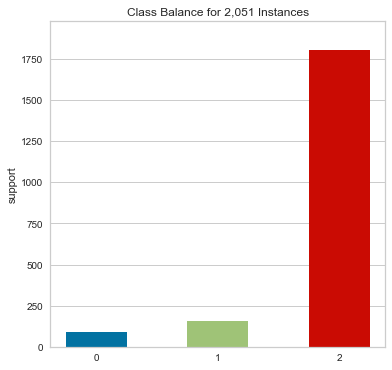

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (6,6))
cb_viz = ClassBalance(labels = ["0","1","2"])
cb_viz.fit(y_test)
cb_viz.poof()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


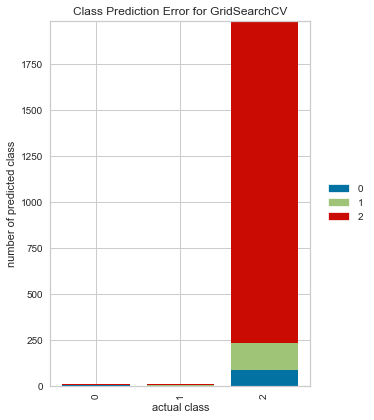

In [49]:
#Class prediction error
from yellowbrick.classifier import ClassPredictionError
fig, ax = plt.subplots(figsize = (6,6))
cpe_viz = ClassPredictionError(model, classes = ["0","1","2"])
cpe_viz.score(x_test_vec,y_test)
cpe_viz.poof()

In [52]:
#LSTM with GloVe
import gensim
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

In [53]:
#使用GloVe建立baseline model
def create_corpus_new(df):
    corpus = []
    for tweet in tqdm(df['review']):
        words = [word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

In [54]:
corpus=create_corpus_new(X_data_df)

100%|██████████| 10254/10254 [00:01<00:00, 5650.98it/s]


In [55]:
#使用GloVe建立词嵌入字典：
embedding_dict={}
with open('/Users/yfy/Desktop/NLP项目/glove.6B.50d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [56]:
#预设参数：
MAX_LEN = 50
tokenizer_obj = Tokenizer() #使用tf.keras.的Tokenizer分词器
tokenizer_obj.fit_on_texts(corpus) #对目标文本进行分词处理，参数texts：要用以训练的文本列表
#用在待转为序列的文本列表，返回序列的列表，列表中每个序列对应于一段输入文本
sequences = tokenizer_obj.texts_to_sequences(corpus) 
#maxlen设置最大的序列长度，长于该长度的序列将会截短，短于该长度的序列将会填充
tweet_pad = pad_sequences(sequences,maxlen = MAX_LEN,truncating = 'post',padding='post')

In [57]:
#将单词（字符串）映射为它们的排名或者索引。仅在调用fit_on_texts之后设置。
word_index = tokenizer_obj.word_index
print('Number of unique words:', len(word_index))

Number of unique words: 31642


In [58]:
#初始化字符串长度
num_words = len(word_index)+1
#初始化一个全部为0的矩阵
embedding_matrix = np.zeros((num_words,50))

for word, i in tqdm(word_index.items()):
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec

100%|██████████| 31642/31642 [00:00<00:00, 725355.76it/s]


In [59]:
#建立基于GloVe的baseline模型
model = Sequential()
embedding = Embedding(num_words,50,embeddings_initializer = Constant(embedding_matrix), 
                     input_length = MAX_LEN, trainable = False)

In [69]:
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout = 0.2))
model.add(Dense(1,activation = 'softmax'))
optimzer = Adam(learning_rate = 3e-4)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1582150   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               60400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1, 50)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [71]:
x_train_vec = tf_idf.fit_transform(X_data_df.review.values)
train = tweet_pad[:x_train_vec.shape[0]]
test = tweet_pad[train.shape[0]:]

In [72]:
X_train,X_test,y_train,y_test=train_test_split(train,y,test_size=0.2,random_state = 42, shuffle = True)

In [73]:
#推进的epochs值为10-20
history = model.fit(X_train,y_train,batch_size=4,epochs =5,validation_data=(X_test,y_test),verbose=2)

Epoch 1/5
2051/2051 - 21s - loss: 0.0000e+00 - accuracy: 0.0779 - val_loss: 0.0000e+00 - val_accuracy: 0.0648
Epoch 2/5
2051/2051 - 20s - loss: 0.0000e+00 - accuracy: 0.0779 - val_loss: 0.0000e+00 - val_accuracy: 0.0648
Epoch 3/5
2051/2051 - 20s - loss: 0.0000e+00 - accuracy: 0.0779 - val_loss: 0.0000e+00 - val_accuracy: 0.0648
Epoch 4/5
2051/2051 - 19s - loss: 0.0000e+00 - accuracy: 0.0779 - val_loss: 0.0000e+00 - val_accuracy: 0.0648
Epoch 5/5
2051/2051 - 19s - loss: 0.0000e+00 - accuracy: 0.0779 - val_loss: 0.0000e+00 - val_accuracy: 0.0648
